 ## Better SWAP Gates

I choose to work on the challenge which involved creating better swap gates.
I started by analyzing the schedules that Qiskit creates for a swap gate. The swap gate is decomposed in three CNOT gates.
The first thing I noticed is that swap(0,1) is treated differently than swap(1,0) even tho they should have the same outcome. This is inefficient because the u channels are directional and CR puses can only be created in one direction. In this case because the CR is from 1 to 0, swap(0,1) ends up having more gates than swap(1,0) because it also needs the H gates to invert the CNOTS.
The second thing I noticed is that single qubit pulses that end up next to each other from the neighboring CNOT gates can be merged into a single pulse in order to reduce gate time.
Finlay I noticed that the CNOT gate has the same effect if it is traversed from left to right or from right to left. This means that the order of the pulses that make up a CNOT gate can be reversed. If I reversed the order of the pulses that make up the leftmost CNOT then I end up with the single qubit pulses towards the middle of the schedule, next to the pulses from the middle CNOT. Then I can merge this single qubit pulses and further reduce gate time.
In short I took these steps:
    1. For any pair of qubits choose the order that gives the least number of gates in a native SWAP schedule
    2. In this schedule identify the three CNOT gates.
    3. For the leftmost CNOT reverse the order of the pulses.
    4. Merge any neighboring single-qubit pulses into one.
    5. Use this schedule for both diection of SWAPs between the 2 qubits (swap(0,1) and swap(1,0)) 

The resulting schedule for each pair is visible in the notebook


In [1]:
### Install Qiskit and other modules if you don't have them already
!pip install -r dependencies/requirements.txt --quiet

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'dependencies/requirements.txt'


In [2]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_bloch_vector
import numpy as np
from qiskit import QuantumCircuit, BasicAer, execute, IBMQ
from qiskit import transpile, schedule as build_schedule
from qiskit.test.mock import FakeAlmaden, FakeAthens
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.compiler import assemble
from qiskit.providers.aer.pulse import duffing_system_model

from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit import pulse

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

simulator = PulseSimulator()
model = PulseSystemModel.from_backend(backend)

c:\users\sorin\anaconda3\envs\qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [4]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

directed_pairs = [(1,0), (1,2), (3,1), (5,3), (5,4), (6,5)]
CR_instructions = {}
CR_negative_instrunctions = {}
rotary_echo_instructions = {}
rotary_echo_negative_instructions = {}
x_on_control = {}
sx_on_control = {}
sx_on_targhet = {}
z_90_on_targhet = {}
z_neg180_on_target = {}
z_neg90_on_target = {}
z_neg90_on_control = {}
z_neg180_on_control = {}

In [5]:
def sum_instructions(instructions):
    sched=instructions[0][1]
    for ins in instructions[1:]:
        sched += ins[1]
        
    return sched
        
for pair in directed_pairs:
    instructions = inst_sched_map._map['cx'][pair].bind_parameters().instructions
    rotary = instructions[-5][1]
    cr = instructions[-4][1]
    rotary_ngative = instructions[-2][1]
    cr_negative = instructions[-1][1]
    
    control = pair[0]
    target = pair[1]
    
    x_control = inst_sched_map._map['x'][(control,)].bind_parameters().instructions[0][1]
    sx_control = inst_sched_map._map['sx'][(control,)].bind_parameters().instructions[0][1]
    sx_target = inst_sched_map._map['sx'][(target,)].bind_parameters().instructions[0][1]
    
    z_90_targhet = sum_instructions(inst_sched_map._map['rz'][(target,)].bind_parameters(np.pi/2).instructions)
    z_neg90_target = sum_instructions(inst_sched_map._map['rz'][(target,)].bind_parameters(-np.pi/2).instructions)
    z_neg180_target = sum_instructions(inst_sched_map._map['rz'][(target,)].bind_parameters(-np.pi).instructions)
    z_neg180_control = sum_instructions(inst_sched_map._map['rz'][(control,)].bind_parameters(-np.pi).instructions)
    z_neg90_control = sum_instructions(inst_sched_map._map['rz'][(control,)].bind_parameters(-np.pi/2).instructions)
    
    CR_instructions[pair] = cr
    CR_negative_instrunctions[pair] = cr_negative
    rotary_echo_instructions[pair] = rotary
    rotary_echo_negative_instructions[pair] = rotary_ngative
    x_on_control[pair] = x_control
    sx_on_control[pair] = sx_control
    sx_on_targhet[pair] = sx_target
    z_90_on_targhet[pair] = z_90_targhet
    z_neg180_on_target[pair] = z_neg180_target
    z_neg90_on_target[pair] = z_neg90_target
    z_neg90_on_control[pair] = z_neg90_control
    z_neg180_on_control[pair] = z_neg180_control
    
def build_swap(pair):
    with pulse.build(name='custom_swap_'+str(pair[0])+str(pair[1])) as sched:
        with pulse.align_sequential():
            pulse.call(CR_negative_instrunctions[pair]+rotary_echo_negative_instructions[pair])
            x_c = x_on_control[pair]
            pulse.play(x_c.operands[0], x_c.operands[1])
            pulse.call(CR_instructions[pair] + rotary_echo_instructions[pair])
            
            pulse.call(z_90_on_targhet[pair])
            sx_c = sx_on_control[pair]
            pulse.play(sx_c.operands[0], sx_c.operands[1])
            
            pulse.call(CR_instructions[pair] + rotary_echo_instructions[pair])
            pulse.play(x_c.operands[0], x_c.operands[1])
            pulse.call(CR_negative_instrunctions[pair]+rotary_echo_negative_instructions[pair])

            pulse.call(z_neg180_on_target[pair])
            pulse.call(z_neg90_on_control[pair])
            pulse.call(sx_on_control[pair]+sx_on_targhet[pair])
            pulse.call(z_neg90_on_target[pair])
            pulse.call(z_neg180_on_control[pair])
            
            pulse.call(CR_instructions[pair] + rotary_echo_instructions[pair])
            pulse.play(x_c.operands[0], x_c.operands[1])
            pulse.call(CR_negative_instrunctions[pair]+rotary_echo_negative_instructions[pair])
    return sched

custom_swaps = {}
for pair in directed_pairs:
    sched=build_swap(pair)
    custom_swaps[pair] = sched
    custom_swaps[(pair[1],pair[0])] = sched

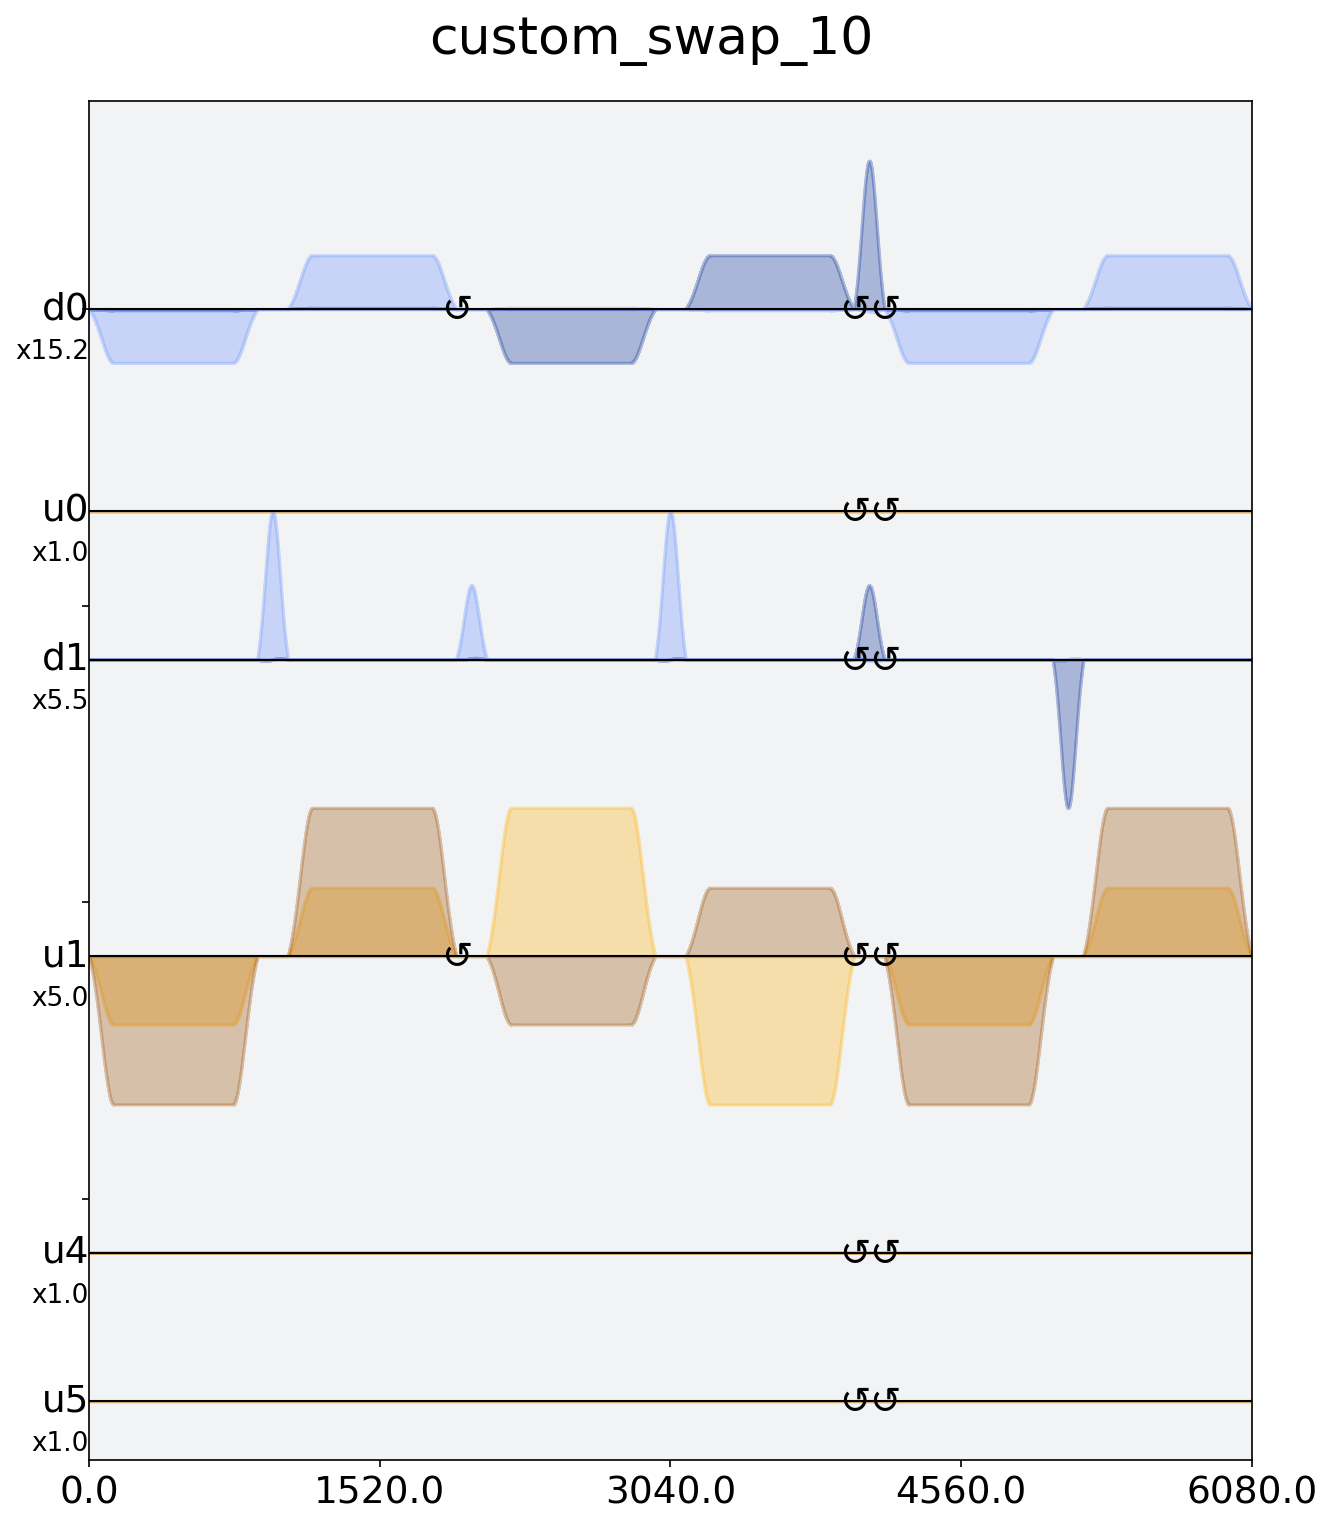

In [6]:
custom_swaps[(0,1)].draw()

In [8]:
# Needed for functions
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import display, clear_output

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, schedule, assemble, execute
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Interleaved randomized benchmarking functions
from qiskit.ignis.verification import randomized_benchmarking as rb
from qiskit.ignis.verification import InterleavedRBFitter

# Measurement mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

ibmqfactory.load_account:WARNING:2021-04-17 05:52:22,069: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
coupling_map = backend.configuration().coupling_map
gate_errors_cx = [backend.properties().gate_error('cx', qubit_pair) for qubit_pair in coupling_map]

for qubit_pair, gate_error_cx in zip(coupling_map, gate_errors_cx):
    print("Qubit pair {} has cx error {:.4f}".format(qubit_pair, gate_error_cx))

best_cx_error = min(gate_errors_cx)
best_qubit_pair = coupling_map[gate_errors_cx.index(min(gate_errors_cx))]
print("Best cx gate is qubit pair {} with cx error {:.4f} ({:.2f}%)".format(best_qubit_pair, best_cx_error, best_cx_error*100))

Qubit pair [0, 1] has cx error 0.0145
Qubit pair [1, 0] has cx error 0.0145
Qubit pair [1, 2] has cx error 0.0275
Qubit pair [1, 3] has cx error 0.0087
Qubit pair [2, 1] has cx error 0.0275
Qubit pair [3, 1] has cx error 0.0087
Qubit pair [3, 5] has cx error 0.0096
Qubit pair [4, 5] has cx error 0.0083
Qubit pair [5, 3] has cx error 0.0096
Qubit pair [5, 4] has cx error 0.0083
Qubit pair [5, 6] has cx error 0.0070
Qubit pair [6, 5] has cx error 0.0070
Best cx gate is qubit pair [5, 6] with cx error 0.0070 (0.70%)


In [ ]:
# do RB on swap gate between the qubits that have the cx gate with lowest error
q1 = best_qubit_pair[0]
q2 = best_qubit_pair[1]

# generate the RB circuit parameters
length_vector = np.arange(1,200,20)
nseeds = 5
rb_pattern = [[q1,q2]]

In [ ]:
# Specify the interleaved element, i.e. the gate to be characterized
qc_swap = QuantumCircuit(2)

qc_swap.swap(0, 1)

qc_swap.add_calibration('swap', (q1,q2), custom_swaps[(q1,q2)])
qc_swap.add_calibration('swap', (q2,q1), custom_swaps[(q2,q1)])

interleaved_elem = [qc_swap]

In [ ]:
rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                             nseeds=nseeds,
                                             rb_pattern=rb_pattern,
                                             interleaved_elem=interleaved_elem)

In [ ]:
for circuits in circuits_interleaved:
    for circuit in circuits:
        circuit.add_calibration("swap", qubits=[q1, q2], schedule=custom_swaps[(q1,q2)])
        circuit.add_calibration("swap", qubits=[q2, q1], schedule=custom_swaps[(q2,q1)])

In [ ]:
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
result_list = []
transpile_list = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    job_monitor(job)
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

In [ ]:
# Plot the non-interleaved RB results
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [ ]:
# Execute the interleaved RB circuits
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
interleaved_result_list = []
interleaved_transpile_list = []
for rb_seed,rb_circ_seed in enumerate(circuits_interleaved):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    interleaved_result_list.append(job.result())
    interleaved_transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

In [ ]:
# Plot the interleaved RB circuit results
rbfit = rb.fitters.RBFitter(interleaved_result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(interleaved_result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [ ]:
# Extract the interleaved results and plot
rb_fit_interleaved = InterleavedRBFitter(result_list, interleaved_result_list, xdata, rb_pattern)

In [ ]:
plt.figure(figsize=(8, 8))
axis = [plt.subplot(1, 1, 1)]
rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)